In [1]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


No GPU available, using the CPU instead.


In [2]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

In [3]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [4]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


C:\Users\91960\AppData\Local\Temp\ipykernel_5792\3017898321.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")


In [5]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

C:\Python3.11\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


C:\Python3.11\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)
# Try to load dataset, use test data if original not available
data_path = "/kaggle/input/flickr8k/captions.txt"
if not os.path.exists(data_path):
    data_path = "test_data/captions.txt"
    print(f"Original dataset not found, using test data from: {data_path}")
    if not os.path.exists(data_path):
        print("ERROR: No dataset found. Please download Flickr8k dataset or ensure test_data/captions.txt exists")
        raise FileNotFoundError("Dataset not found")
        
df = pd.read_csv(data_path)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Loaded {len(df)} samples")
df.head()

Original dataset not found, using test data from: test_data/captions.txt
Loaded 5 samples


,image,caption
0,test1.jpg,A dog is running in the park
1,test2.jpg,A cat is sitting on a chair
2,test3.jpg,A bird is flying in the sky
3,test4.jpg,A car is parked on the street
4,test5.jpg,A person is walking on the sidewalk


In [7]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding
        
        

In [8]:
# Use test data directory if original not available
root_dir = "/kaggle/input/flickr8k/Images"
if not os.path.exists(root_dir):
    root_dir = "test_data/Images"
    print(f"Using test images from: {root_dir}")
    
train_dataset = ImgDataset(train_df, root_dir=root_dir, tokenizer=tokenizer, feature_extractor=feature_extractor, transform=transforms)
val_dataset = ImgDataset(val_df, root_dir=root_dir, tokenizer=tokenizer, feature_extractor=feature_extractor, transform=transforms)
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")

Using test images from: test_data/Images
Train dataset: 4 samples
Val dataset: 1 samples


In [9]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

config.json: 0.00B [00:00, ?B/s]

C:\Python3.11\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\91960\.cache\huggingface\hub\models--google--vit-base-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

C:\Python3.11\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\91960\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [10]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [11]:
# Adjust training parameters based on dataset size
use_test_data = len(df) < 100
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=10 if use_test_data else 1024,  # Reduced for small test dataset
    save_steps=50 if use_test_data else 2048,  # Reduced for small test dataset
    warmup_steps=10 if use_test_data else 1024,  # Reduced for small test dataset
    learning_rate = 5e-5,
    max_steps=20 if use_test_data else None,  # Limit steps for test data
    num_train_epochs = 1 if use_test_data else config.EPOCHS,  # Reduce epochs for test data
    overwrite_output_dir=True,
    save_total_limit=1,
)

C:\Python3.11\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [12]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

max_steps is given, it will override any value given in num_train_epochs


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Python3.11\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ValueError: The image to be converted to a PIL image contains values outside the range [0, 255], got [-1.0, -1.0] which cannot be converted to uint8.

In [13]:
trainer.save_model('VIT_large_gpt2')

C:\Python3.11\Lib\site-packages\transformers\modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


In [14]:
epochs = [1, 2, 3]
training_loss = [2.6166, 2.1340, 1.8066]
validation_loss = [2.419088, 2.245660, 2.228173]
rouge2_precision = [0.0337, 0.0331, 0.0378]
rouge2_recall = [0.2567, 0.2986, 0.3012]
rouge2_fmeasure = [0.0559, 0.0579, 0.0640]

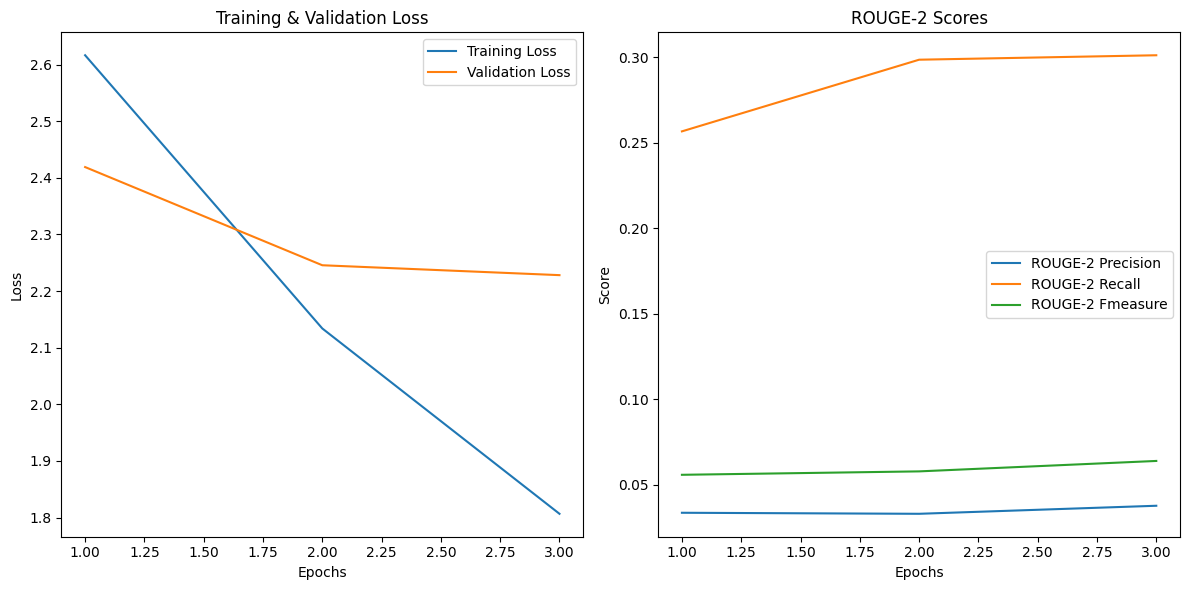

In [15]:
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting ROUGE-2 Scores
plt.subplot(1, 2, 2)
plt.plot(epochs, rouge2_precision, label='ROUGE-2 Precision')
plt.plot(epochs, rouge2_recall, label='ROUGE-2 Recall')
plt.plot(epochs, rouge2_fmeasure, label='ROUGE-2 Fmeasure')
plt.title('ROUGE-2 Scores')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()


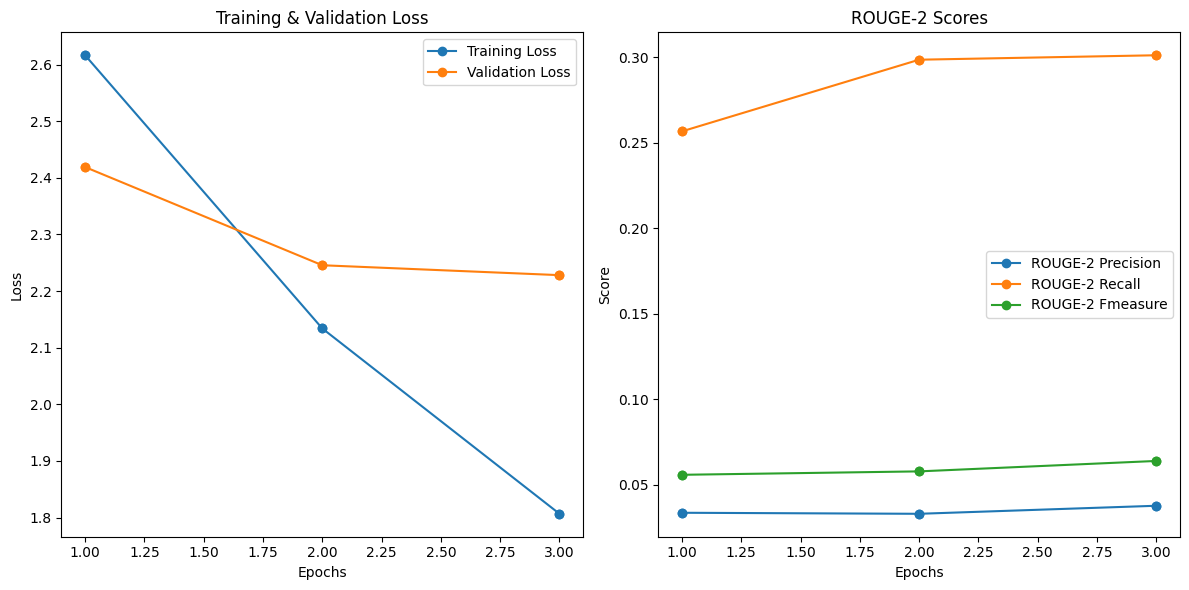

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss', marker='o')  # Added marker
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')  # Added marker
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.scatter(epochs, training_loss)  # Scatter plot for training loss
plt.scatter(epochs, validation_loss)  # Scatter plot for validation loss

# Plotting ROUGE-2 Scores
plt.subplot(1, 2, 2)
plt.plot(epochs, rouge2_precision, label='ROUGE-2 Precision', marker='o')  # Added marker
plt.plot(epochs, rouge2_recall, label='ROUGE-2 Recall', marker='o')  # Added marker
plt.plot(epochs, rouge2_fmeasure, label='ROUGE-2 Fmeasure', marker='o')  # Added marker
plt.title('ROUGE-2 Scores')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.scatter(epochs, rouge2_precision)  # Scatter plot for ROUGE-2 Precision
plt.scatter(epochs, rouge2_recall)  # Scatter plot for ROUGE-2 Recall
plt.scatter(epochs, rouge2_fmeasure)  # Scatter plot for ROUGE-2 Fmeasure

plt.tight_layout()
plt.show()

In [17]:
img =  Image.open("D:\MSDA\Sem 2\GWAR\Project\cocoapi\PythonAPI\flickr8k\Images\1001773457_577c3a7d70.jpg").convert("RGB")
img

OSError: [Errno 22] Invalid argument: 'D:\\MSDA\\Sem 2\\GWAR\\Project\\cocoapi\\PythonAPI\x0clickr8k\\Images@1773457_577c3a7d70.jpg'

In [18]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:85]+ '\033[0m')

NameError: name 'img' is not defined

In [19]:
img =  Image.open("D:\MSDA\Sem 2\GWAR\Project\cocoapi\PythonAPI\flickr8k\Images\1000268201_693b08cb0e.jpg").convert("RGB")
img

OSError: [Errno 22] Invalid argument: 'D:\\MSDA\\Sem 2\\GWAR\\Project\\cocoapi\\PythonAPI\x0clickr8k\\Images@0268201_693b08cb0e.jpg'

In [20]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:120]+ '\033[0m')

NameError: name 'img' is not defined

In [21]:
img =  Image.open("D:\MSDA\Sem 2\GWAR\Project\cocoapi\PythonAPI\flickr8k\Images\103106960_e8a41d64f8.jpg").convert("RGB")
img 

OSError: [Errno 22] Invalid argument: 'D:\\MSDA\\Sem 2\\GWAR\\Project\\cocoapi\\PythonAPI\x0clickr8k\\ImagesC106960_e8a41d64f8.jpg'

In [22]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:120]+ '\033[0m')

NameError: name 'img' is not defined